In [1]:
from fenics import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
from egfcore import *
from utils import *

set_log_level(30)
%matplotlib widget

Text(0, 0.5, 'y')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
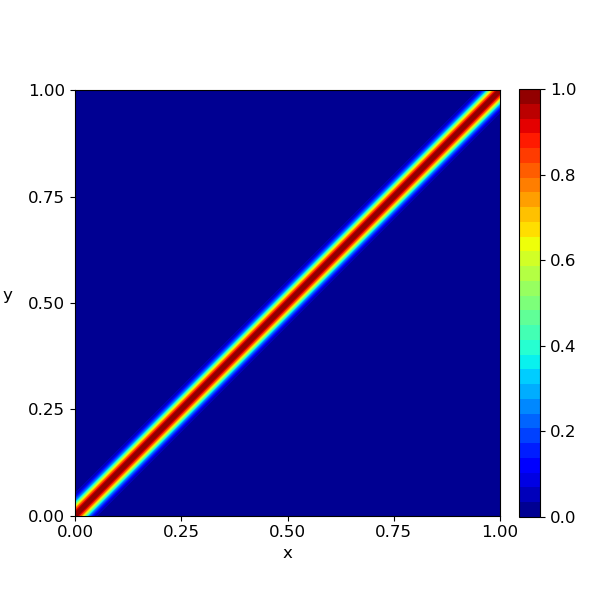

In [11]:
vmin = 0
vmax = 1
size = 12

sigma = 0.7
domain = [0, 1]
domain_length = domain[-1]-domain[0]

xx = np.linspace(domain[0],domain[1], 2001)
x, y = np.meshgrid(xx,xx)
kernel = np.exp((-(x-y)**2) / (2*(domain_length**2) * sigma**22))

fig = plt.figure(figsize = (6,6))
    
levels = np.linspace(vmin, vmax, 30)
surf = plt.contourf(x, y, kernel, levels = levels, cmap = 'jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks([0,0.25,0.5,0.75,1.0], size = size)
plt.yticks([0,0.25,0.5,0.75,1.0], size = size)
cbar = plt.colorbar(fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 6))
cbar.ax.tick_params(labelsize=size)
plt.xlabel('x', size = size)
plt.ylabel('y', rotation='horizontal', labelpad=15, size = size)
# plt.title(f"GP Covariance Kernel", size = 15)
# plt.axis('off')
# plt.savefig("interp-A.png", bbox_inches = 'tight',pad_inches = 0)

(-1.0946127895614899,
 1.0997434661695948,
 -1.098588157888158,
 1.098588157888158)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
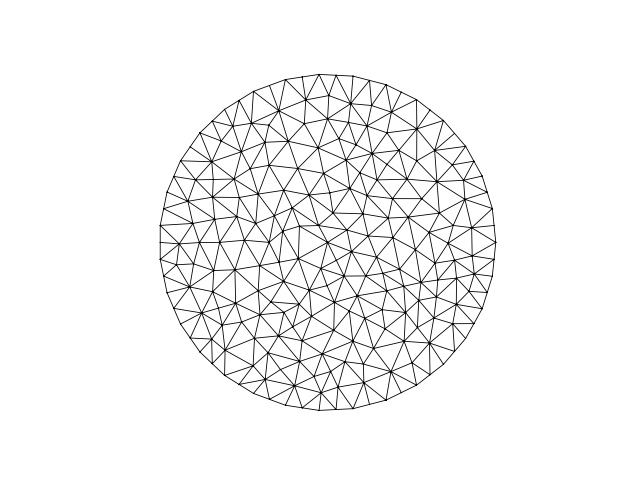

In [3]:
meshDensity = 10
circle = mshr.Circle(Point(0.0,0.0), 1.0)
mesh = mshr.generate_mesh(circle, meshDensity)  
plt.figure()
plot(mesh, alpha = 1, color = 'k', linewidth = 0.6)
plt.axis('off')

In [4]:
class Simulator:
    
    def __init__(self, meshDensity):
        self.mesh = IntervalMesh(meshDensity,0,1) # (meshDensity = N_sensors) =  # of positions at which the problem is discretized on a unit interval
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh.mat", mesh_dict)
        self.V = FunctionSpace(self.mesh, 'P', 2)
        
        # Define the function space and store the meshweights for computation.
        V = FunctionSpace(self.mesh,'P',1)
        u = TestFunction(V)
        temp = assemble(u*dx)
        self.meshweights = (temp.get_local()[vertex_to_dof_map(V)]).reshape(-1,1)
        
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh2D.mat", mesh_dict)
        
        # Create variational form for the problem
        self.bc = self.boundaryConditions()
        u = TrialFunction(self.V)
        v = TestFunction(self.V)
        self.f = Function(V)
        self.param = Constant(0)
        self.d2v = dof_to_vertex_map(V)
        self.a = dot(grad(u), grad(v))* dx
        self.L = self.f*v*dx
        self.u = Function(self.V)
        
    def boundaryConditions(self):
        """
        Define homogeneous Dirichlet Boundary conditions for the problem.
        """
        def boundary(x, on_boundary):
            return on_boundary
        
        u_D = Constant(0)
        bc = DirichletBC(self.V, u_D, boundary)
        
        return bc
    
    def solve(self, forcing, noise_level = None, param=None):
        """
        Given a (N_sensors x 1) forcing vector, solve the a 1D Poisson problem on a unit interval.
        """
        
        self.f.vector()[:] = forcing[self.d2v] # Instantiate the source term in the variational form by interpolating the sampled sourcing term.
        if param is not None:
            self.param.assign(param) # Define the parameter for the problem
        solve(self.a == self.L, self.u, self.bc) # Solve the variation form

        # Sample the solution at the nodes of the mesh.
        solution = self.u.compute_vertex_values(self.mesh)
        
        # As specified, add IID Gaussian white noise.
        if noise_level is not None:
            noise =  noise_level*np.random.normal(0,np.abs(solution.mean()),solution.shape)
            solution += noise
        
        return solution

In [43]:
%%time
params = np.array([0])
add_noise = False
noise_level = 0.1
verbose = False

meshDensity = 2000
sigma = 0.01
rank = 100
nSamples = rank

np.random.seed(42)
    
print(f"Method: Randomized SVD | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")
Sim = Simulator(meshDensity)

meshweights = Sim.meshweights

# Generate an forcing and output ensemble by simulating Poisson problem with FENICS.
forcing = sampleforcing(sigma, nSamples)
solution = np.zeros(forcing.shape)
for i in range(solution.shape[1]):
    if verbose:
        print("i = %d / %d"%(i+1, solution.shape[1]))
    if add_noise:
        solution[:,i] = Sim.solve(forcing[:,i], noise_level)
    else:
        solution[:,i] = Sim.solve(forcing[:,i])

if add_noise:
    modelrandomized = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, noise_level, None, None, Sim, verbose = verbose)
else:
    modelrandomized = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, None, None, None, Sim, verbose = verbose)

Method: Randomized SVD | meshDensity: 2000, sigma: 0.01, nSamples: 100, rank: 100, Noise: False
CPU times: user 1.55 s, sys: 314 ms, total: 1.87 s
Wall time: 11.1 s


In [44]:
plt.close('all')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
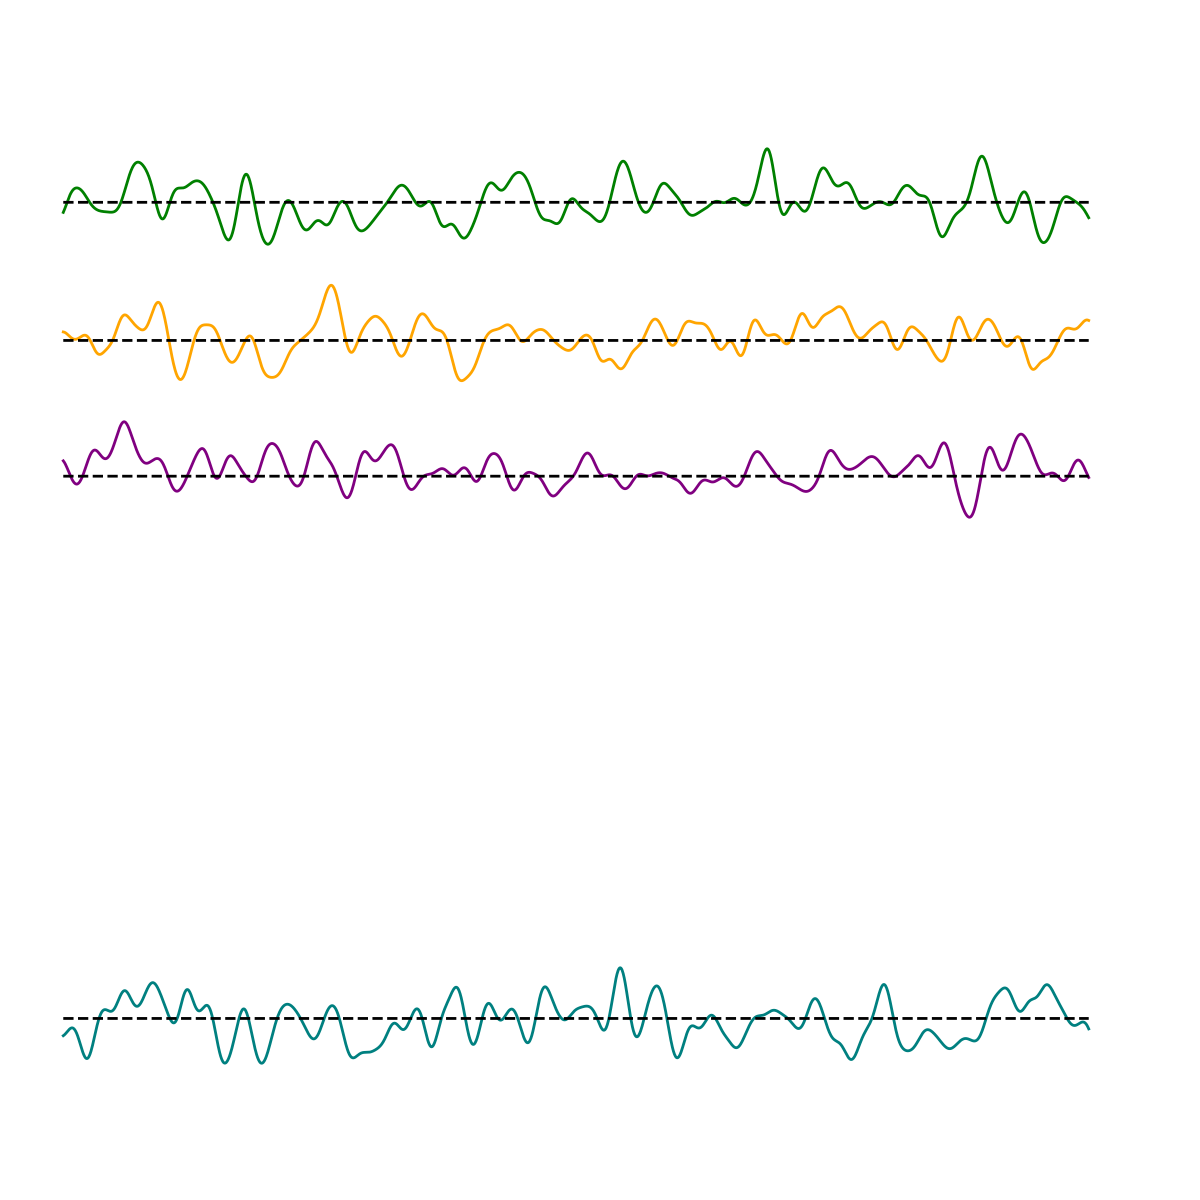

In [47]:

fig = plt.figure(figsize = (12,12))

plt.tight_layout()
grid = plt.GridSpec(7, 1, wspace = 0.2, hspace = 0.3, left = 0.01)
plt.subplots_adjust(left = 0.4, right = 0.95)

plts = [0,1,2,6]
colors = ['green','orange','purple', 'teal']
for j,i in enumerate(plts):
    plt.subplot(grid[i,0])

    plt.plot(xx, forcing[:,i], color = colors[j], linewidth = 2)
    plt.plot(xx, 0 * xx, 'k--', linewidth = 2)
    plt.axis('off')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
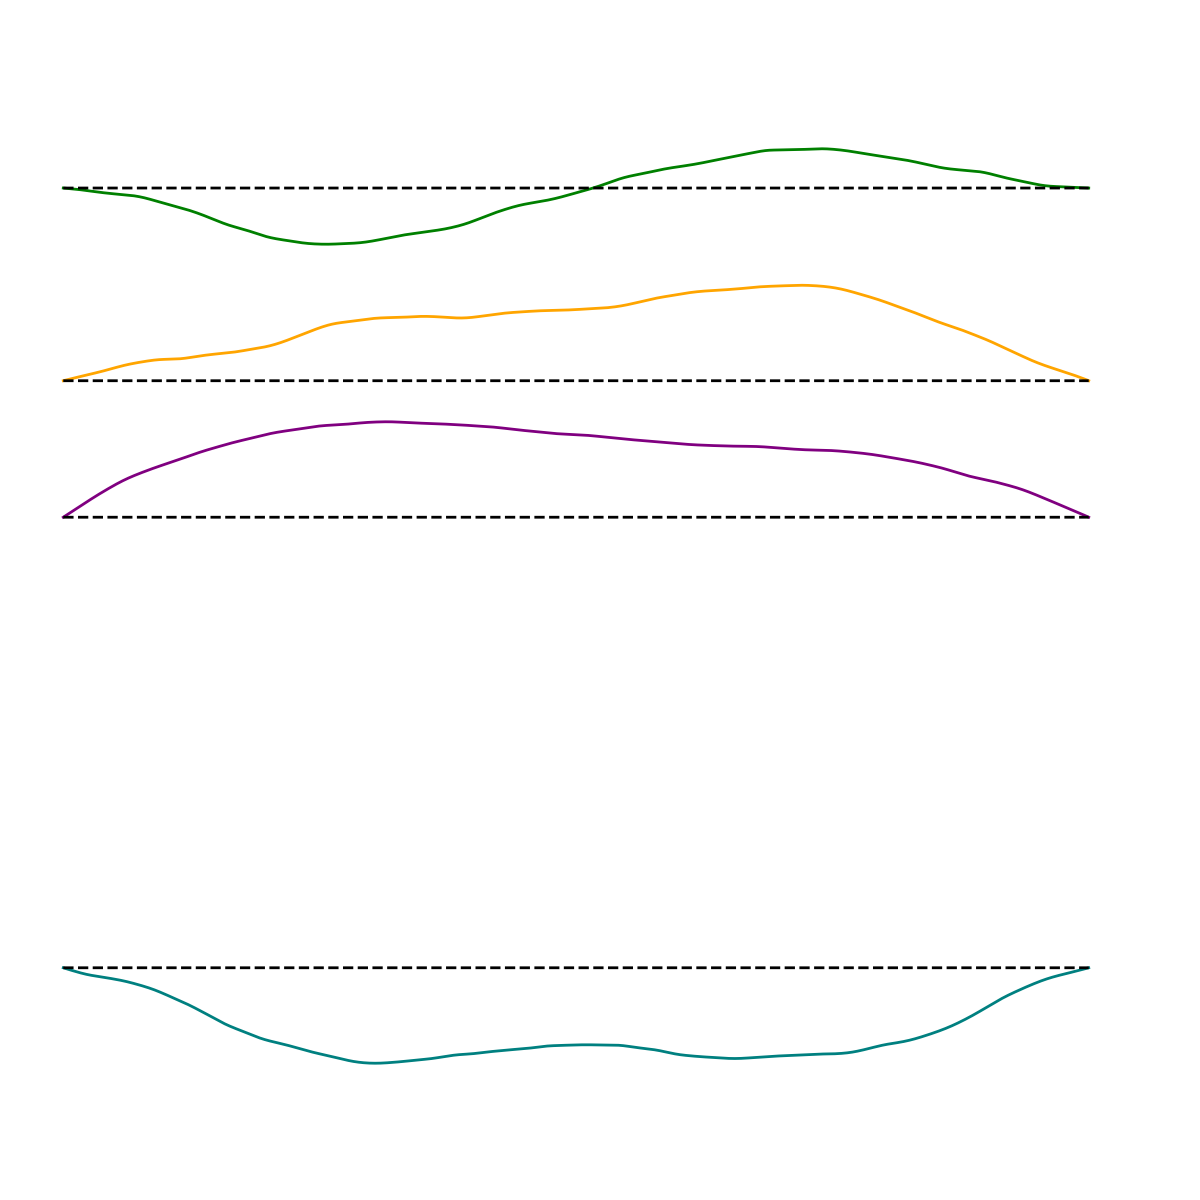

In [48]:

fig = plt.figure(figsize = (12,12))

plt.tight_layout()
grid = plt.GridSpec(7, 1, wspace = 0.2, hspace = 0.3, left = 0.01)
plt.subplots_adjust(left = 0.4, right = 0.95)

plts = [0,1,2,6]
colors = ['green','orange','purple', 'teal']
for j,i in enumerate(plts):
    plt.subplot(grid[i,0])

    plt.plot(xx, solution[:,i], color = colors[j], linewidth = 2)
    plt.plot(xx, 0 * xx, 'k--', linewidth = 2)
    plt.axis('off')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
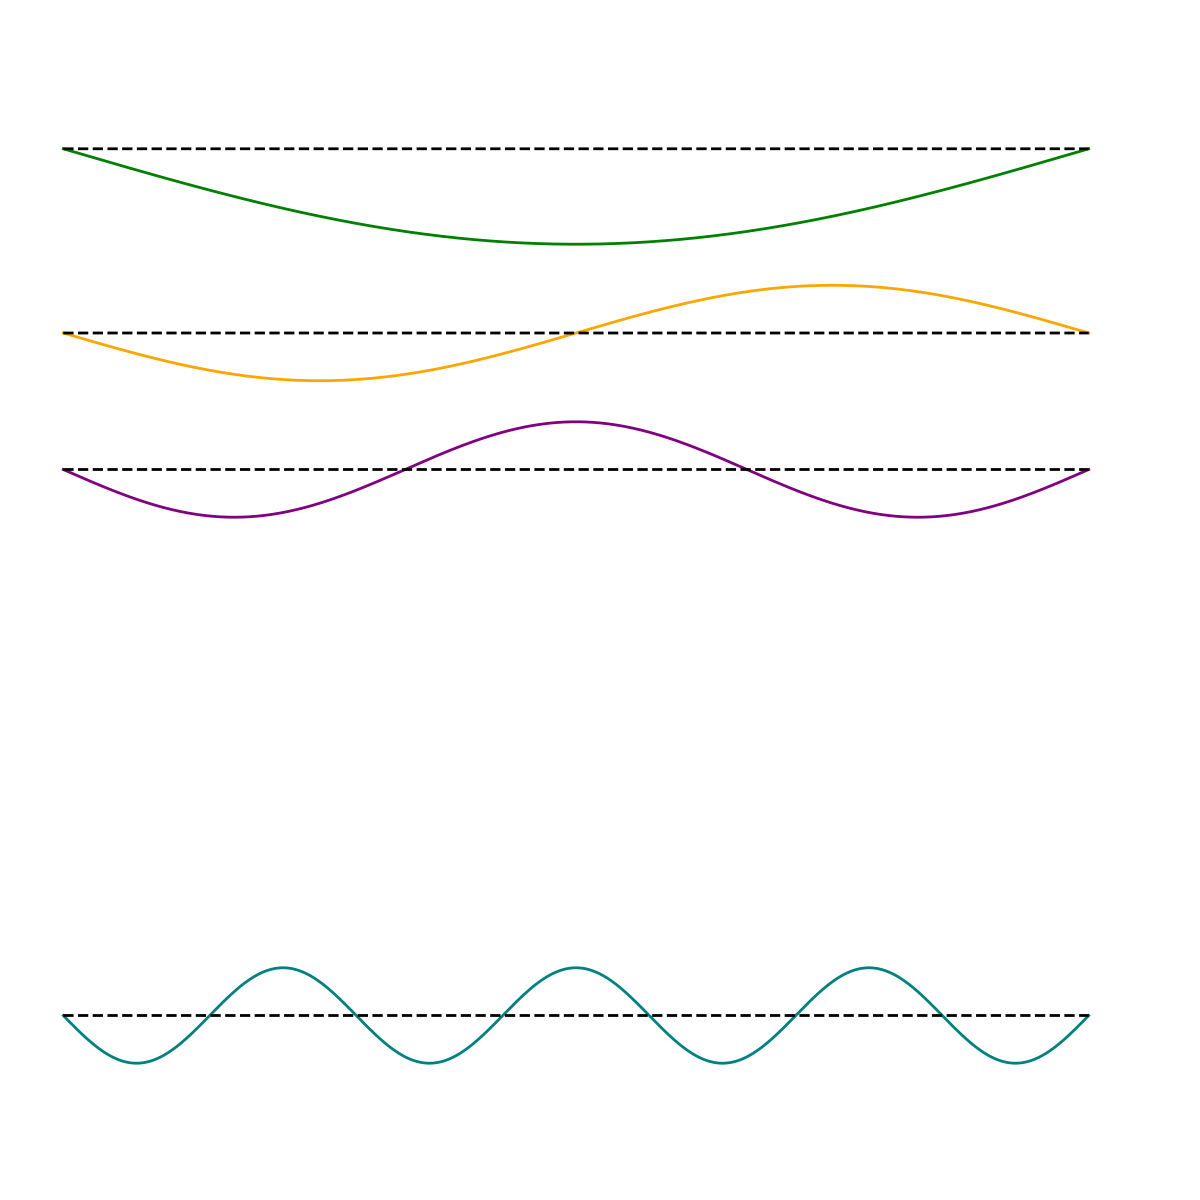

In [50]:
fig = plt.figure(figsize = (12,12))

plt.tight_layout()
grid = plt.GridSpec(7, 1, wspace = 0.2, hspace = 0.3, left = 0.01)
plt.subplots_adjust(left = 0.4, right = 0.95)

plts = [0,1,2,6]
colors = ['green','orange','purple', 'teal']
for j,i in enumerate(plts):
    plt.subplot(grid[i,0])

    plt.plot(xx, modelrandomized.modeset[:,i], color = colors[j], linewidth = 2)
    plt.plot(xx, 0 * xx, 'k--', linewidth = 2)
    plt.axis('off')